# Validation of Korteweg-de Vries Solver against Analytical Solution

TODO

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
import exponax as ex

In [3]:
sech = lambda x: 1 / jnp.cosh(x)

In [4]:
c = 5.0
a = 10.0
analytical = lambda t, x: -1 / 2 * c * (sech(jnp.sqrt(c) / 2 * (x - c * t - a))) ** 2

In [5]:
grid = ex.make_grid(1, 20.0, 128)

In [6]:
u_0 = analytical(0, grid)

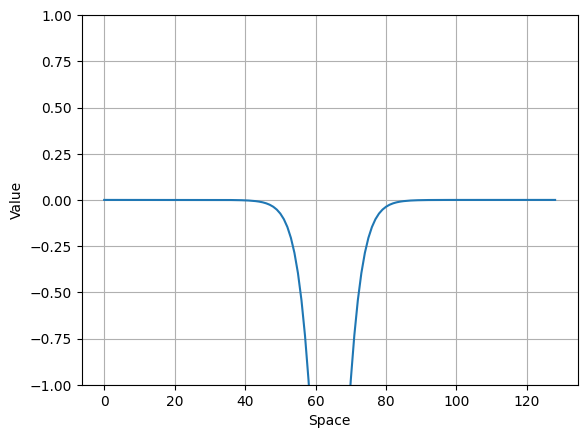

In [7]:
ex.viz.plot_state_1d(u_0)

In [8]:
kdv_stepper = ex.stepper.KortewegDeVries(
    1,
    20.0,
    128,
    0.001,
    convection_scale=-6,
    diffusivity=0.0,
    dispersivity=1.0,
    hyper_diffusivity=0.0,
)

In [9]:
trj_stepper = ex.rollout(kdv_stepper, 5000, include_init=True)(u_0)

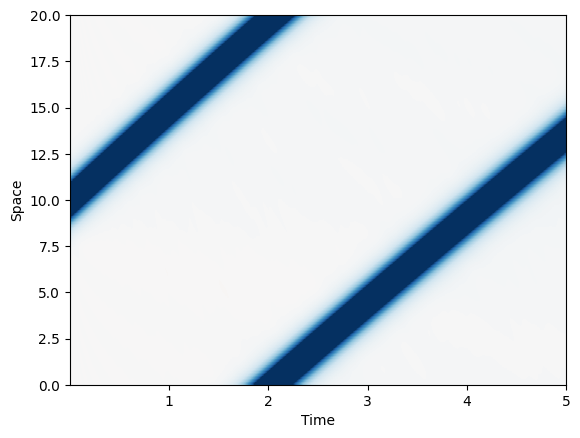

In [10]:
ex.viz.plot_spatio_temporal(
    trj_stepper, domain_extent=kdv_stepper.domain_extent, dt=kdv_stepper.dt
)

In [11]:
stepper_state_after_one = trj_stepper[1000]
analytical_state_after_one = analytical(1000 * kdv_stepper.dt, grid)

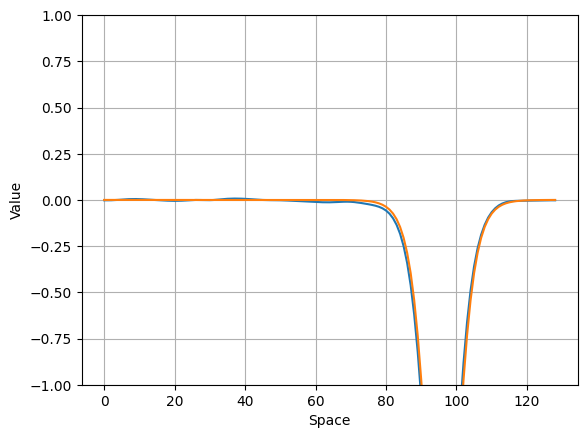

In [12]:
ex.viz.plot_state_1d(
    jnp.concatenate([stepper_state_after_one, analytical_state_after_one])
)

In [13]:
def rel_error(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

In [14]:
rel_error(stepper_state_after_one, analytical_state_after_one)

Array(0.06026487, dtype=float32)